In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import time
import json

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Reshape, Flatten
from tensorflow.keras.utils import to_categorical

tfd = tfp.distributions

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# EDA

In [47]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(35535, 784) (35535, 62)
(4044, 784) (4044, 62)


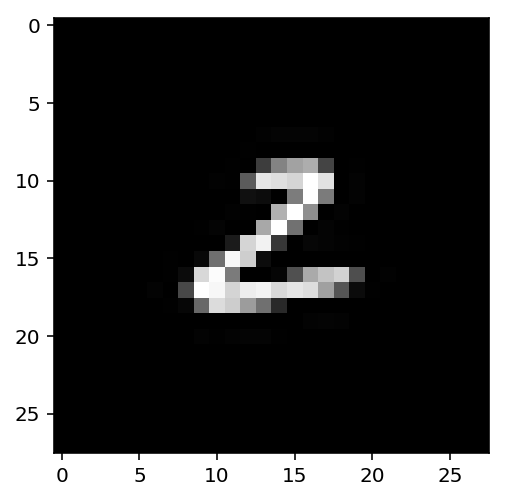

In [133]:
plt.imshow(
    np.array(x_train[10]).reshape((28,28)), 
    cmap='Greys');

In [134]:
tfd.Normal(loc=[0,0], scale=[1/10, 1/10]).log_prob(np.array([[1,2],[1,2]]))

<tf.Tensor: id=620021, shape=(2, 2), dtype=float32, numpy=
array([[ -48.616352, -198.61635 ],
       [ -48.616352, -198.61635 ]], dtype=float32)>

In [ ]:
latent_net.set_weights()

In [833]:
class LatentVarNet(tf.keras.Model):
    
    def __init__(self):
        super(LatentVarNet, self).__init__()
        
        self.reshape = Reshape((28,28,1), input_shape=(784,))
        self.conv1 = Conv2D(16, 3, padding='same', activation='relu')
        self.pool1 = MaxPooling2D(strides=2)
        self.conv2 = Conv2D(32, 3, padding='same', activation='relu')
        self.pool2 = MaxPooling2D(strides=2)
        self.flatten = Flatten()
        self.layer1 = Dense(256, activation='relu')
        self.out = Dense(62, activation='softmax')
        
        self.z_matrix = tf.Variable(tf.random.normal([190, 10], mean=0, stddev=1), trainable=True)
        self.z_prior = tfd.Normal(loc=[0]*10, scale=[1]*10)
        
    def call(self, x, k):
        
        z = tf.gather(self.z_matrix, k)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.layer1(x)
        x = tf.concat([x, z], axis=1)
        x = self.out(x)
        
        self.add_loss(self.z_prior.log_prob(z))
        return x

In [909]:
class LatentVarNet(tf.keras.Model):
    
    def __init__(self):
        super(LatentVarNet, self).__init__()
        
        self.reshape = Reshape((28,28,1), input_shape=(784,))
        self.conv1 = Conv2D(16, 3, padding='same', activation='relu')
        self.pool1 = MaxPooling2D(strides=2)
        self.conv2 = Conv2D(32, 3, padding='same', activation='relu')
        self.pool2 = MaxPooling2D(strides=2)
        self.flatten = Flatten()
        self.layer1 = Dense(256, activation='relu')
        self.out = Dense(62, activation='softmax')
        
        #self.zmu = tf.Variable(tf.zeros((190, 10)), trainable=True)
        #self.zsig = tf.Variable(tf.ones((190, 10)), trainable=True)
        #self.z_prior = tfd.Normal(loc=[0]*10, scale=[1]*10)
     
    #@tf.function
    def call(self, x, k):
        # batch x 2
        #mu = tf.gather(self.zmu, k)
        #sig = tf.gather(self.zsig, k)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.layer1(x)
        # batch x 2
        #eps = tfd.Normal(0,1).sample()
        # batch x 2
        #z = eps*tf.exp(sig) + mu
        #x = tf.concat([x, z], axis=1)
        x = self.out(x)
        #self.add_loss(self.z_prior.log_prob(z))
        return x

In [909]:
class LatentVarNet(tf.keras.Model):
    
    def __init__(self):
        super(LatentVarNet, self).__init__()
        
        self.reshape = Reshape((28,28,1), input_shape=(784,))
        self.conv1 = Conv2D(16, 3, padding='same', activation='relu')
        self.pool1 = MaxPooling2D(strides=2)
        self.conv2 = Conv2D(32, 3, padding='same', activation='relu')
        self.pool2 = MaxPooling2D(strides=2)
        self.flatten = Flatten()
        self.layer1 = Dense(256, activation='relu')
        self.out = Dense(62, activation='softmax')
        
        self.zmu = tf.Variable(tf.zeros((190, 10)), trainable=True)
        self.zsig = tf.Variable(tf.ones((190, 10)), trainable=True)
        self.z_prior = tfd.Normal(loc=[0]*10, scale=[1]*10)
     
    #@tf.function
    def call(self, x, k):
        # batch x 2
        mu = tf.gather(self.zmu, k)
        sig = tf.gather(self.zsig, k)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.layer1(x)
        # batch x 2
        eps = tfd.Normal(0,1).sample()
        # batch x 2
        z = eps*tf.exp(sig) + mu
        x = tf.concat([x, z], axis=1)
        x = self.out(x)
        self.add_loss(self.z_prior.log_prob(z))
        
        return x

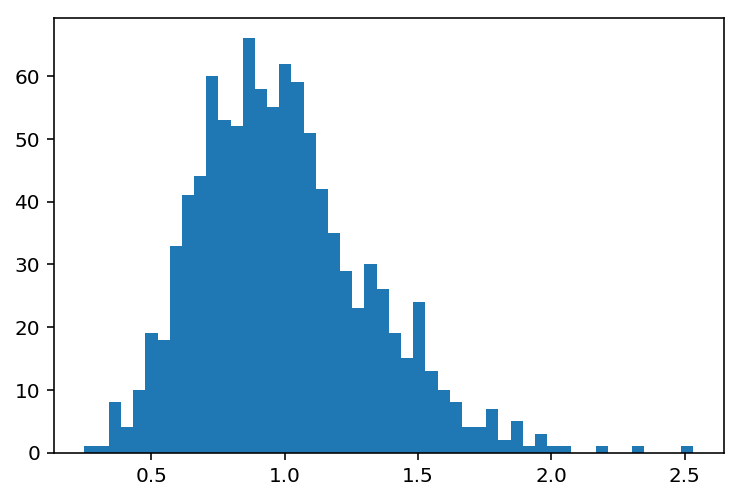

In [1018]:
plt.hist(tfd.Gamma(10,10).sample(1000).numpy(),bins=50);

In [1023]:
tfd.Normal(0,1).sample([190, 10]).shape

TensorShape([190, 10])

In [1025]:
.shape

TensorShape([2, 10])

In [1031]:
tfd.MultivariateNormalDiag(
    loc=tf.gather(tfd.Normal(0,1).sample([190, 10]), [1,2]), 
    scale_diag=tf.nn.softplus(tf.gather(tfd.Gamma(10,10).sample([190, 10]),  [1,2]) + softplus_inverse(1.0))
).sample()

<tf.Tensor: id=19698729, shape=(2, 10), dtype=float32, numpy=
array([[-1.154278  , -0.8409508 ,  1.7322991 , -1.8095245 , -4.4815936 ,
         0.9163297 ,  0.5670719 , -0.14488089, -2.8384576 ,  1.1169329 ],
       [ 4.133394  ,  0.38667542,  2.0486479 , -0.5724343 ,  2.0195491 ,
        -2.5362558 , -0.9643404 ,  2.201728  , -1.9887775 ,  0.5985199 ]],
      dtype=float32)>

In [109]:
def softplus_inverse(x):
    """Helper which computes the function inverse of `tf.nn.softplus`."""
    return tf.math.log(tf.math.expm1(x))

class LatentVarNet(tf.keras.Model):
    
    def __init__(self, z_dim):
        super(LatentVarNet, self).__init__()
        self.z_dim = 10
        
        self.reshape = Reshape((28,28,1), input_shape=(784,))
        self.conv1 = Conv2D(16, 3, padding='same', activation='relu')
        self.pool1 = MaxPooling2D(strides=2)
        self.conv2 = Conv2D(32, 3, padding='same', activation='relu')
        self.pool2 = MaxPooling2D(strides=2)
        self.flatten = Flatten()
        self.layer1 = Dense(256, activation='relu')
        self.out = Dense(62, activation='softmax')
        
        self.zmu = tf.Variable(tfd.Normal(0,1).sample([190, self.z_dim]))
        self.zsig = tf.Variable(tfd.Gamma(10,10).sample([190, self.z_dim]))
        self.z_prior = tfd.MultivariateNormalDiag(loc=[0]*self.z_dim, scale_diag=[1]*self.z_dim)
     
    #@tf.function
    def call(self, x, k):
        
        mu = tf.gather(self.zmu, k)
        sig = tf.gather(self.zsig, k)
        approx_posterior = tfd.MultivariateNormalDiag(
            loc=mu, scale_diag=tf.nn.softplus(sig + softplus_inverse(1.0)))
        z = approx_posterior.sample() 
        
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.layer1(x) 
        x = tf.concat([x, z], axis=1)
        x = self.out(x)
        
        print(tfd.kl_divergence(approx_posterior, self.z_prior))
        self.add_loss(tfd.kl_divergence(approx_posterior, self.z_prior))
        return x

In [110]:
latent_net = LatentVarNet(10)

In [112]:
latent_net(x_train[:2], users_train_id[:2]);

tf.Tensor([8.0649605 8.0649605], shape=(2,), dtype=float32)


In [1040]:
latent_net.summary()

Model: "latent_var_net_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_50 (Reshape)         multiple                  0         
_________________________________________________________________
conv2d_100 (Conv2D)          multiple                  160       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin multiple                  0         
_________________________________________________________________
conv2d_101 (Conv2D)          multiple                  4640      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin multiple                  0         
_________________________________________________________________
flatten_50 (Flatten)         multiple                  0         
_________________________________________________________________
dense_74 (Dense)             multiple            

In [1041]:
[x.shape for x in latent_net.trainable_weights]

[TensorShape([3, 3, 1, 16]),
 TensorShape([16]),
 TensorShape([3, 3, 16, 32]),
 TensorShape([32]),
 TensorShape([1568, 256]),
 TensorShape([256]),
 TensorShape([266, 62]),
 TensorShape([62]),
 TensorShape([190, 10]),
 TensorShape([190, 10])]

In [1042]:
def batch_generator(x, y, z, batch_size=100):
    size = x.shape[0]
    indexes = np.random.permutation(size)
    i = 0
    while True:
        idx = indexes[i:i+batch_size]
        yield x[idx], y[idx], z[idx]
        i = (i + batch_size) % size
        
def create_batch_partition(x, y, z, batch_size=100):
    size = x.shape[0]
    indexes = np.random.permutation(size)
    i = 0
    data = []
    while i < size:
        idx = indexes[i:i+batch_size]
        data.append((x[idx], y[idx], z[idx]))
        i = (i + batch_size)
    return data

In [571]:
tf.gather(latent_net.z_matrix, [1])

<tf.Tensor: id=6388834, shape=(1, 10), dtype=float32, numpy=
array([[-0.7168208 ,  0.34077615,  0.26927438, -0.29447445,  2.2364993 ,
        -1.0980868 , -0.06240775, -0.98217106,  1.5242196 ,  2.8874335 ]],
      dtype=float32)>

In [511]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, users_train_id))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, users_test_id))
train_dataset = train_dataset.shuffle(1000).batch(10000)
test_dataset = test_dataset.shuffle(1000).batch(100)

In [568]:

for i, (x, y, z) in enumerate(train_dataset):
    print(x.shape)

(10000, 784)
(10000, 784)
(10000, 784)
(5535, 784)


In [327]:
from sklearn.utils import shuffle

In [1044]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cce_loss_fn = tf.keras.losses.CategoricalCrossentropy()

train_generator = create_batch_partition(
    x_train.astype(np.float32), y_train, users_train_id, batch_size=400)
latent_net = LatentVarNet(z_dim=10)

In [1051]:
#@tf.function
def train(model, batch_generator, opt, num_epochs):
    loss_metric = tf.keras.metrics.Mean()
    
    for epoch in range(num_epochs):
        print('--- Epoch {} ---'.format(epoch+1))
        for step, (x, y, z) in enumerate(batch_generator):
            with tf.GradientTape() as tape:
                out = model(x, z)
                loss = cce_loss_fn(y_true=y, y_pred=out) 

            grads = tape.gradient(loss, latent_net.trainable_weights)
            opt.apply_gradients(zip(grads, latent_net.trainable_weights))

            loss_metric(loss)     
        if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs:
            print('Test acc = {}, mean loss = {}'
                  .format(round(accuracy_score(y_true=y_test.argmax(axis=1), 
                                         y_pred=latent_net(x_test, users_test_id).numpy().argmax(axis=1)), 3),
                          round(loss_metric.result().numpy(), 3)))
                
train(latent_net, train_generator, optimizer, num_epochs=10)

--- Epoch 1 ---
--- Epoch 2 ---
--- Epoch 3 ---
--- Epoch 4 ---
--- Epoch 5 ---
Test acc = 0.856, mean loss = 0.21799999475479126
--- Epoch 6 ---
--- Epoch 7 ---
--- Epoch 8 ---
--- Epoch 9 ---
--- Epoch 10 ---
Test acc = 0.848, mean loss = 0.21199999749660492


In [18]:
loss_metric = tf.keras.metrics.Mean()
for epoch in range(10):
    print('Epoch {}'.format(epoch))
    for x in range(20):
        loss = x+epoch
        loss_metric(loss)
    loss_metric.reset_states()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [19]:
loss_metric.result()

<tf.Tensor: id=8417, shape=(), dtype=float32, numpy=0.0>

In [775]:
import pickle

In [688]:
with open('test_model.pickle', 'wb') as f:
    pickle.dump(latent_net.get_weights(), f)

In [690]:
[x.shape for x in latent_net.get_weights()]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (800, 256),
 (256,),
 (266, 62),
 (62,),
 (190, 10),
 (190, 10)]

In [692]:
[x.shape for x in latent_net.trainable_weights]

[TensorShape([3, 3, 1, 16]),
 TensorShape([16]),
 TensorShape([3, 3, 16, 32]),
 TensorShape([32]),
 TensorShape([800, 256]),
 TensorShape([256]),
 TensorShape([266, 62]),
 TensorShape([62]),
 TensorShape([190, 10]),
 TensorShape([190, 10])]

In [1052]:
y_score = latent_net(x_test, users_test_id).numpy()
y_pred = latent_net(x_test, users_test_id).numpy().argmax(axis=1)

In [346]:
from sklearn.metrics import (log_loss, roc_auc_score, accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, precision_score, f1_score, recall_score, precision_recall_curve)

In [143]:
report = classification_report(
    y_true=y_train.argmax(axis=1), 
    y_pred=latent_net(x_train,users_train_id).numpy().argmax(axis=1), output_dict=True)

report = {(i, j): report[i][j]
          for i in report
          for j in report[i]}

report = pd.DataFrame.from_dict(report, orient='index')
report.index = pd.MultiIndex.from_tuples(report.index)
report = report[0].unstack()

In [914]:
log_loss(y_true=y_train, y_pred=latent_net(x_train,users_train_id).numpy())

0.2225714702389099

In [1053]:
log_loss(y_true=y_test, y_pred=latent_net(x_test,users_test_id).numpy())

0.5834138827655159

In [1054]:
accuracy_score(y_true=y_test.argmax(axis=1), 
               y_pred=y_pred)

0.8526211671612265

In [1055]:
f1_score(y_true=y_test.argmax(axis=1), 
               y_pred=y_pred,
         average='weighted')

0.8505367304623327

In [1056]:
roc_auc_score(y_true=y_test, y_score=y_score, average='weighted')

0.9962422722405527

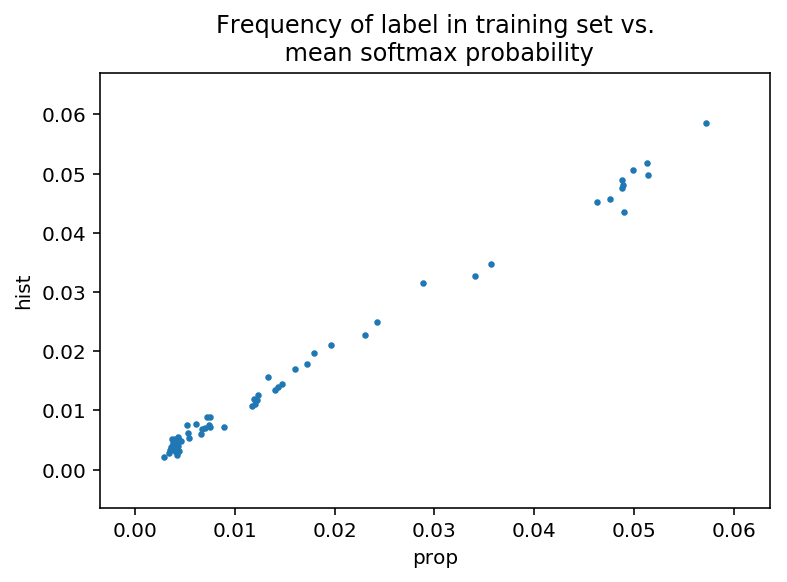

In [1057]:
s1=pd.Series(y_train.argmax(axis=1)).value_counts(normalize=True).sort_index().rename('prop')
s2=pd.Series(latent_net(x_train, users_train_id).numpy().mean(axis=0)).rename('hist')
pd.concat([s1,s2], 1).plot.scatter(x='prop', y='hist', s=5)
plt.title('Frequency of label in training set vs.\n mean softmax probability');

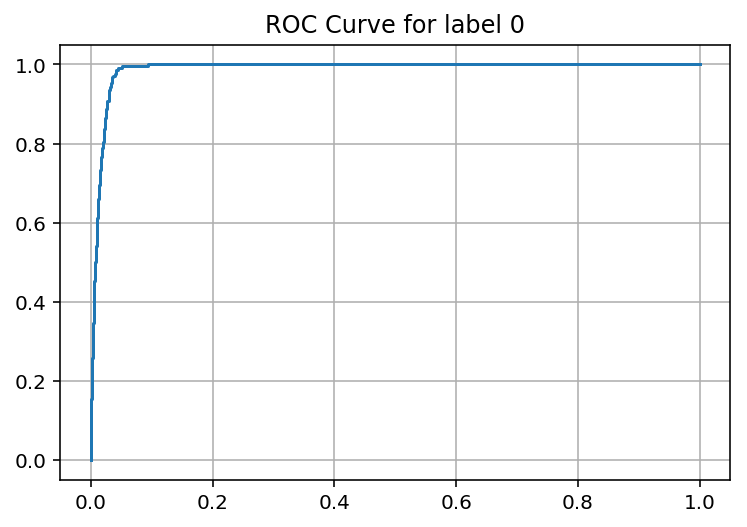

In [532]:
label = 0
fpr, tpr, thresholds = roc_curve(y_true=y_test.argmax(axis=1), 
          y_score=y_score[:,label],
          pos_label=label)

nearest_thresh_idx, pt = get_nearest_pt(np.stack([fpr,tpr]).T, 0, 1)

plt.step(fpr, tpr)
plt.title(f'ROC Curve for label {label}')
plt.grid(True);

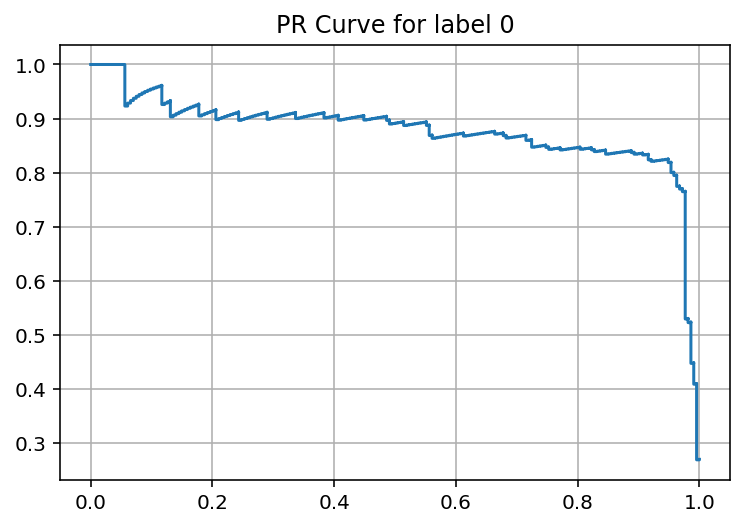

In [400]:
label = 0
precision, recall, thresholds = precision_recall_curve(y_true=y_test.argmax(axis=1), 
          probas_pred=y_score[:,label],
          pos_label=label)

nearest_thresh_idx, pt = get_nearest_pt(np.stack([recall,precision]).T, 1, 1)

plt.step(recall, precision)
plt.title(f'PR Curve for label {label}')
plt.grid(True);

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


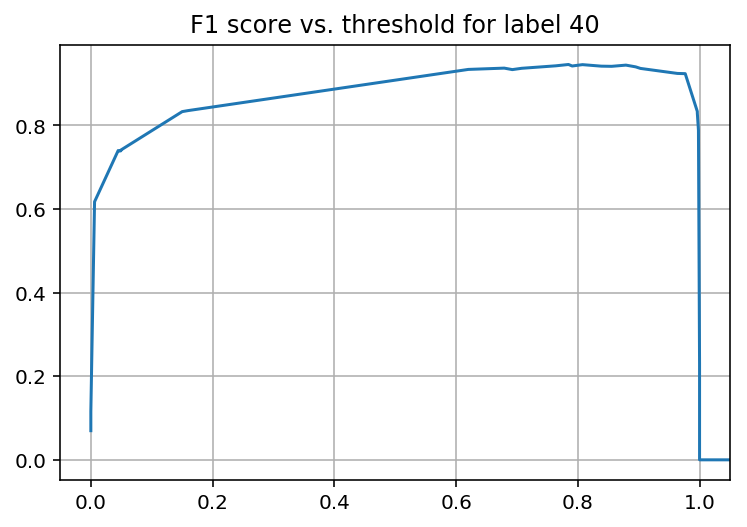

In [401]:

label=40
fpr, tpr, thresholds = roc_curve(y_true=y_test.argmax(axis=1), 
          y_score=y_score[:,label],
          pos_label=label)

nearest_thresh_idx, pt = get_nearest_pt(np.stack([fpr,tpr]).T, 0, 1)

#plt.step(fpr, tpr)
def get_f1_for_thresh(thresh):
    return f1_score(
        y_true=y_test[:,label],
        y_pred=(y_score[:,label] > thresh).astype(int),
        )

get_f1_for_thresh = np.vectorize(get_f1_for_thresh)

plt.plot(thresholds, get_f1_for_thresh(thresholds))
plt.xlim(0-0.05,1+0.05)
plt.grid(True)
plt.title(f'F1 score vs. threshold for label {label}');

In [187]:
accs = []
for label in range(62):
    fpr, tpr, thresholds = roc_curve(y_true=y_test.argmax(axis=1), 
              y_score=latent_net(x_test, users_test_id).numpy()[:,label],
              pos_label=label)

    nearest_thresh_idx, pt = get_nearest_pt(np.stack([fpr,tpr]).T, 0, 1)

    #plt.step(fpr, tpr)
    accs.append(accuracy_score(
        y_true=(y_test.argmax(axis=1)==label).astype(int),
        y_pred=(latent_net(x_test, users_test_id).numpy()[:,label] > thresholds[-nearest_thresh_idx]).astype(int),
        ))

In [215]:
(1-np.array(accs))

array([0.04154303, 0.03709199, 0.00890208, 0.00816024, 0.00667656,
       0.00890208, 0.00544016, 0.00445104, 0.01186944, 0.01533136,
       0.00469832, 0.00296736, 0.01088032, 0.00766568, 0.00717112,
       0.00519288, 0.00296736, 0.0024728 , 0.01063304, 0.00420376,
       0.0024728 , 0.00321464, 0.00593472, 0.00469832, 0.02274975,
       0.00445104, 0.74678536, 0.00321464, 0.012364  , 0.00544016,
       0.01434224, 0.00469832, 0.00395648, 0.00222552, 0.00222552,
       0.00420376, 0.00816024, 0.0049456 , 0.00544016, 0.02720079,
       0.00445104, 0.00667656, 0.00964392, 0.00222552, 0.00296736,
       0.02002967, 0.00346192, 0.02299703, 0.00840752, 0.00840752,
       0.00939664, 0.00519288, 0.00544016, 0.00445104, 0.01582591,
       0.00939664, 0.00964392, 0.00420376, 0.00593472, 0.00346192,
       0.00445104, 0.00321464])

In [380]:
import string
labels = list(string.digits +  string.ascii_uppercase + string.ascii_lowercase)

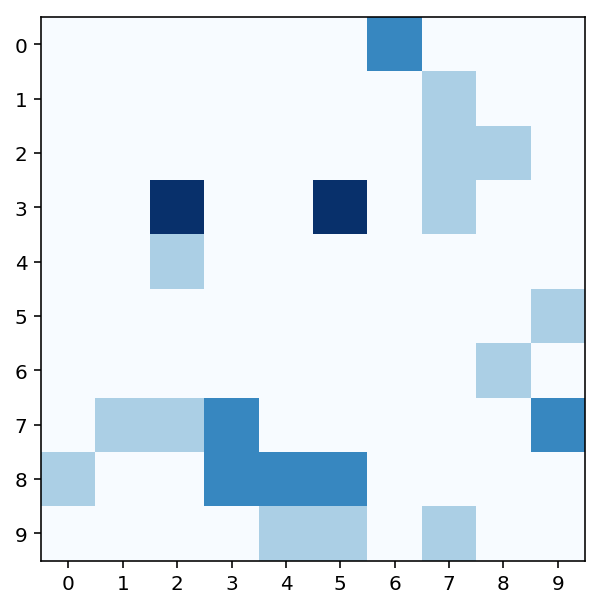

In [655]:
plt.figure(figsize=(5,5))

conf_matrix = confusion_matrix(
    y_true=y_test.argmax(axis=1), 
    y_pred=latent_net(x_test, users_test_id).numpy().argmax(axis=1))[:10,:10]
plt.imshow(conf_matrix - np.diag(np.diag(conf_matrix)), cmap='Blues')
plt.xticks(ticks=range(10), labels=list(string.digits))
plt.yticks(ticks=range(10), labels=list(string.digits));

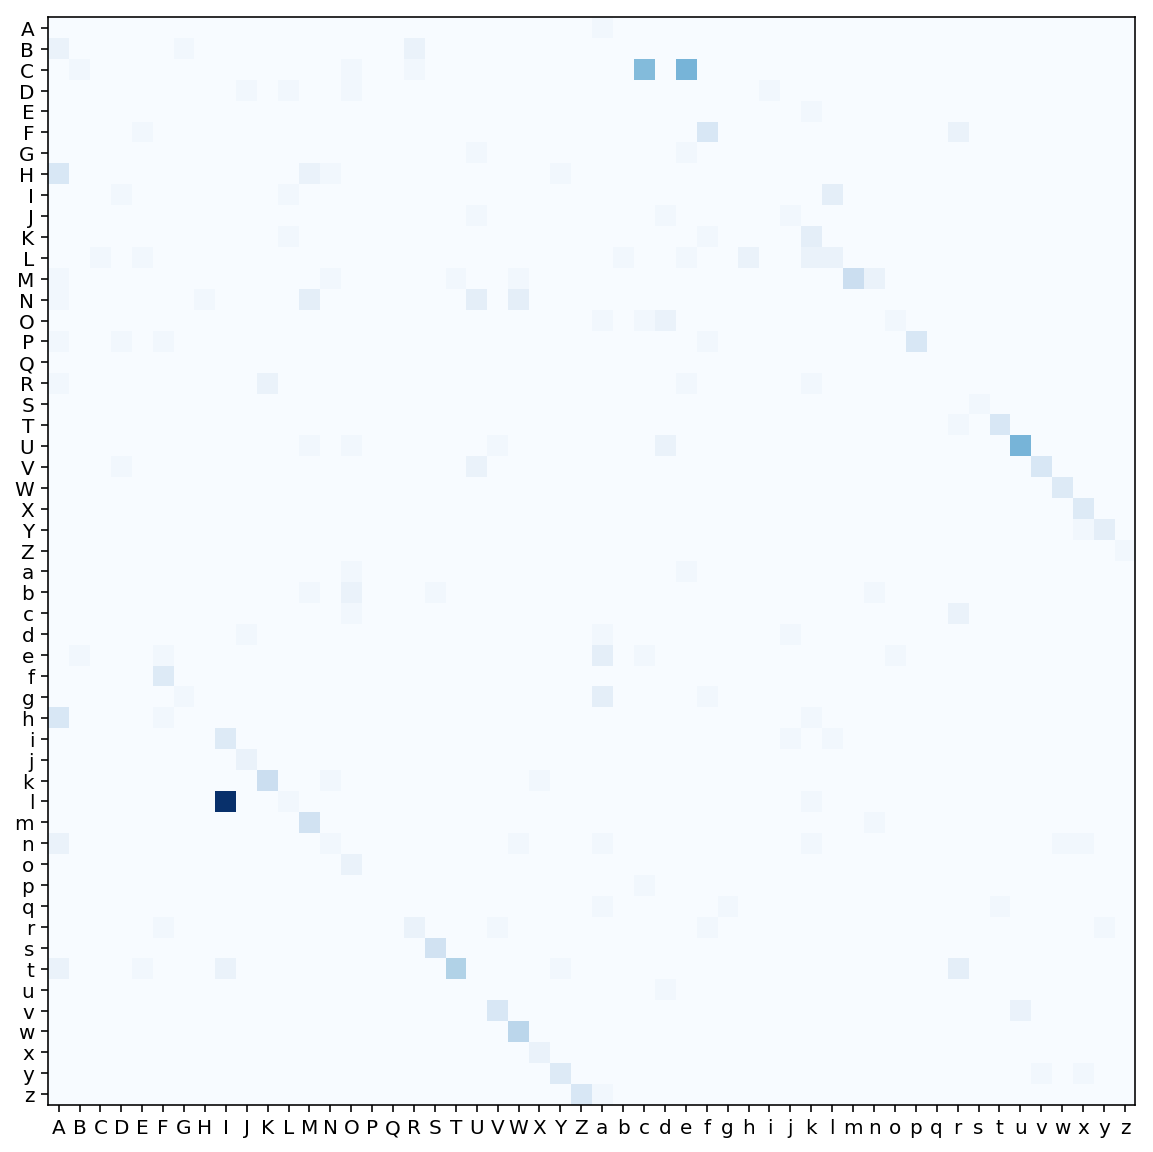

In [656]:
plt.figure(figsize=(10,10))

conf_matrix = confusion_matrix(
    y_true=y_test.argmax(axis=1), 
    y_pred=latent_net(x_test, users_test_id).numpy().argmax(axis=1))[10:,10:]
plt.imshow(conf_matrix - np.diag(np.diag(conf_matrix)), 
          cmap='Blues')
plt.xticks(ticks=range(52), labels=list( string.ascii_uppercase + string.ascii_lowercase ))
plt.yticks(ticks=range(52), labels=list( string.ascii_uppercase + string.ascii_lowercase ));

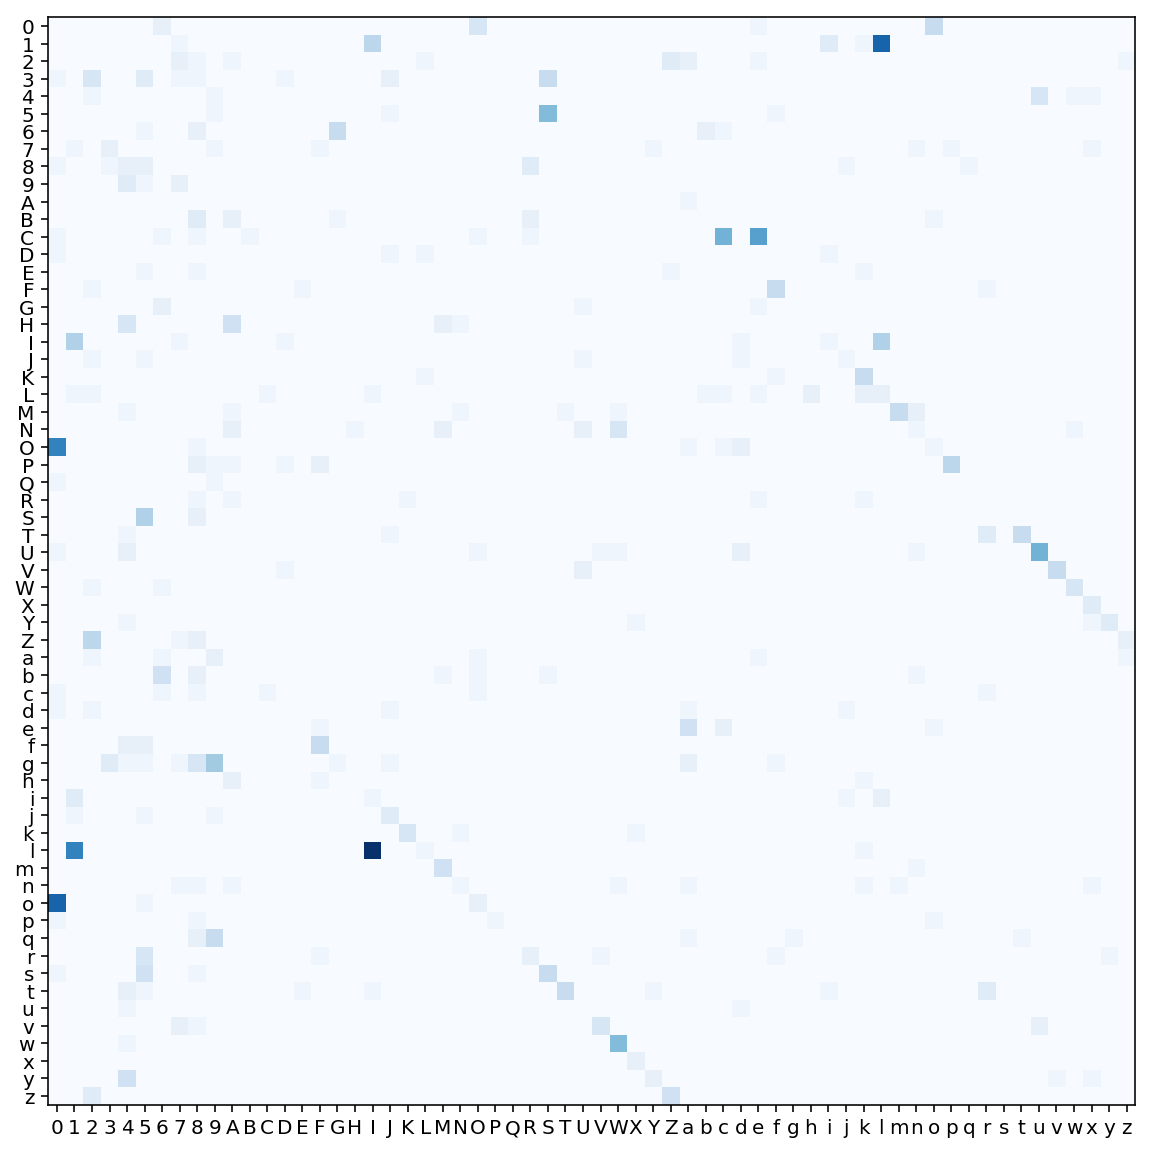

In [657]:
plt.figure(figsize=(10,10))
conf_matrix = confusion_matrix(
    y_true=y_test.argmax(axis=1), 
    y_pred=latent_net(x_test, users_test_id).numpy().argmax(axis=1))
plt.imshow(conf_matrix - np.diag(np.diag(conf_matrix)), cmap='Blues')
plt.xticks(ticks=range(62), labels=labels)
plt.yticks(ticks=range(62), labels=labels);

In [384]:
from sklearn.manifold import TSNE

(array([ 5.,  6., 16., 34., 50., 36., 19., 16.,  6.,  2.]),
 array([-0.11567107,  0.01878112,  0.15323332,  0.2876855 ,  0.4221377 ,
         0.5565899 ,  0.69104207,  0.8254943 ,  0.95994645,  1.0943986 ,
         1.2288508 ], dtype=float32),
 <a list of 10 Patch objects>)

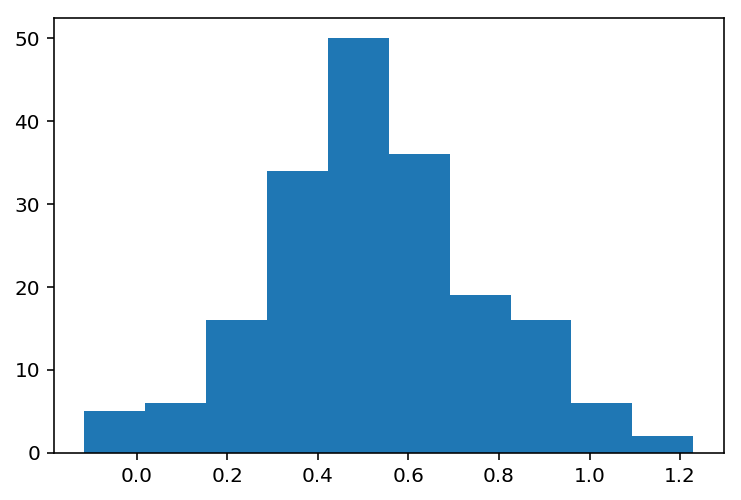

In [669]:
plt.hist(latent_net.zsig[:,3].numpy())

In [841]:
tsne = TSNE(random_state=3)
tsne_latent = tsne.fit_transform(latent_net.z_matrix.numpy())

In [1058]:
tsne = TSNE(random_state=3)
tsne_latent_mu = tsne.fit_transform(latent_net.zmu.numpy())
tsne = TSNE(random_state=3)
tsne_latent_sig = tsne.fit_transform(latent_net.zsig.numpy())

In [454]:
cluster_assign = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

(array([ 2.,  3.,  9., 10., 11., 19., 14., 14., 14., 25.,  7., 15., 11.,
        12.,  8.,  6.,  5.,  2.,  0.,  3.]),
 array([-3.3272324 , -2.9656591 , -2.6040857 , -2.2425125 , -1.8809391 ,
        -1.5193658 , -1.1577924 , -0.79621917, -0.43464583, -0.07307253,
         0.2885008 ,  0.6500741 ,  1.0116475 ,  1.3732207 ,  1.734794  ,
         2.0963674 ,  2.4579406 ,  2.819514  ,  3.1810873 ,  3.5426607 ,
         3.904234  ], dtype=float32),
 <a list of 20 Patch objects>)

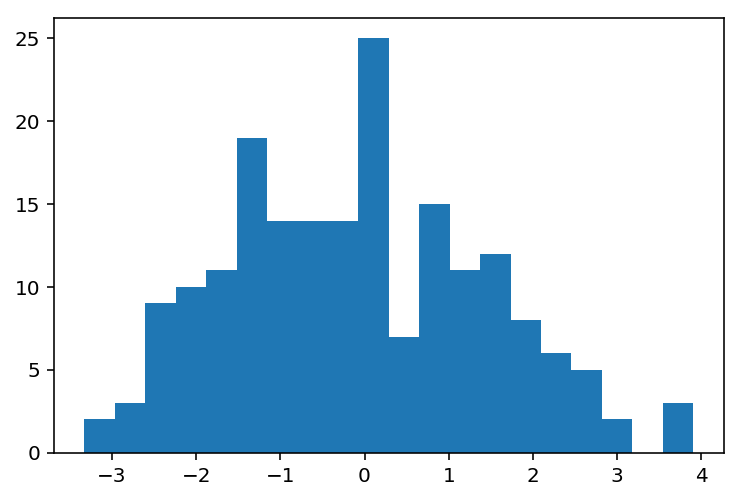

In [1060]:
plt.hist(latent_net.zmu[:,5], bins=20)

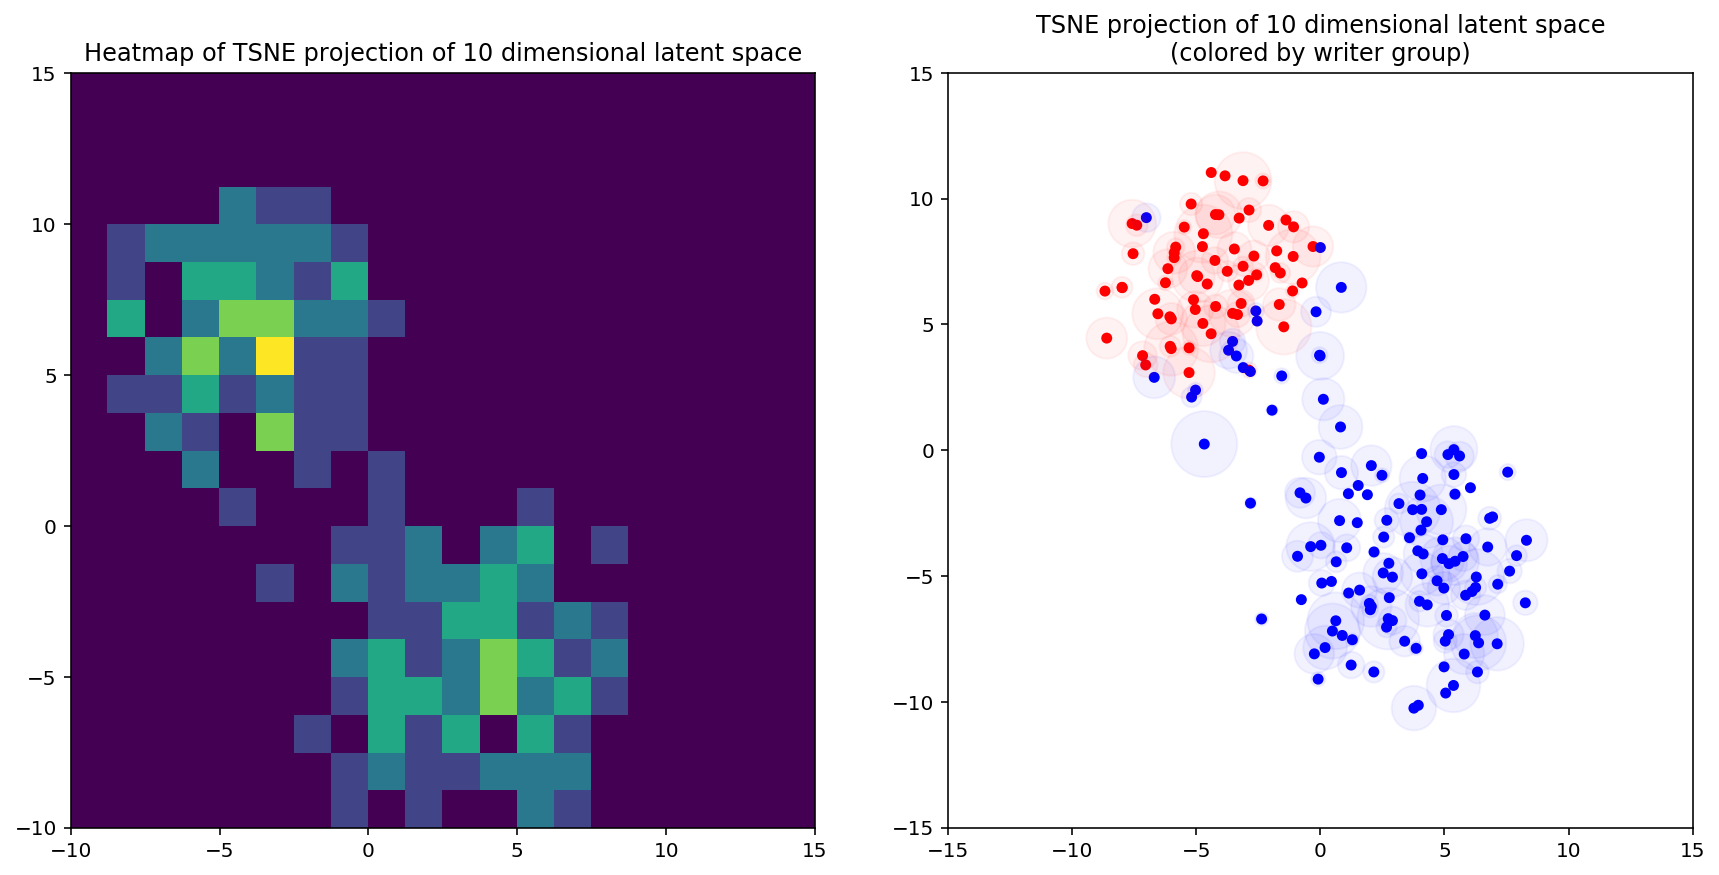

In [1061]:
plt.figure(figsize=(12,6))

plt.subplot(121)
#plt.hist2d(latent_net.z_matrix.numpy()[:,0],latent_net.z_matrix.numpy()[:,1], bins=20,)
#plt.hist2d(latent_net.zmu.numpy()[:,0],latent_net.zmu.numpy()[:,1], bins=20, range=[[-3,3],[-3,3]])
plt.hist2d(tsne_latent_mu[:,0], tsne_latent_mu[:,1], bins=20, range=[[-10,15],[-10,15]])
#plt.hist2d(tsne_latent[:,0], tsne_latent[:,1], bins=20)
plt.title('Heatmap of TSNE projection of 10 dimensional latent space')

plt.subplot(122)
#plt.scatter(latent_net.z_matrix.numpy()[:,0],latent_net.z_matrix.numpy()[:,1], c=cluster_assign, cmap='bwr', s=20)
plt.scatter(tsne_latent_mu[:,0],tsne_latent_mu[:,1], c=cluster_assign, cmap='bwr', s=20)
plt.scatter(tsne_latent_mu[:,0],tsne_latent_mu[:,1], c=cluster_assign, cmap='bwr', s=10*np.square(tsne_latent_sig), alpha=0.05,)
#plt.scatter(tsne_latent[:,0], tsne_latent[:,1], c=cluster_assign, cmap='bwr', s=20)

plt.tight_layout()
plt.xlim(-15,15)
plt.ylim(-15,15)

plt.title('TSNE projection of 10 dimensional latent space\n(colored by writer group)');

In [859]:
def get_nearest_pt(arr, x, y, k=1):
    """
    Get kth nearest pt
    """
    distances = np.sqrt(np.square(arr[:,0] - x) + np.square(arr[:,1] - y))
    idx = np.argpartition(distances, -k)[-k]
    idx = np.argmin(distances)
    pt = arr[idx]
    return idx, pt

def find_x_with_specific_label(x_arr, y_arr, label, k=0):
    """
    Give sample x with a given label
    """
    # find instances of label
    idx = np.where(y_arr.argmax(axis=1) == label)[0]
    return x_arr[idx][k]

def plot_letter_from_writer_at_latent_space_point(x, y, latent_space, label):
    """
    For each coordinate in latent space, find the writer 
    with closest z, plot the same letter/digit for each writer
    """
    idx, pt = get_nearest_pt(latent_space, x, y)
    x_train_id = x_train[np.where(users_train_id == idx)[0]]
    y_train_id = y_train[np.where(users_train_id == idx)[0]]
    
    img = find_x_with_specific_label(x_train_id, y_train_id, label).reshape((28,28))
    return img, pt, idx

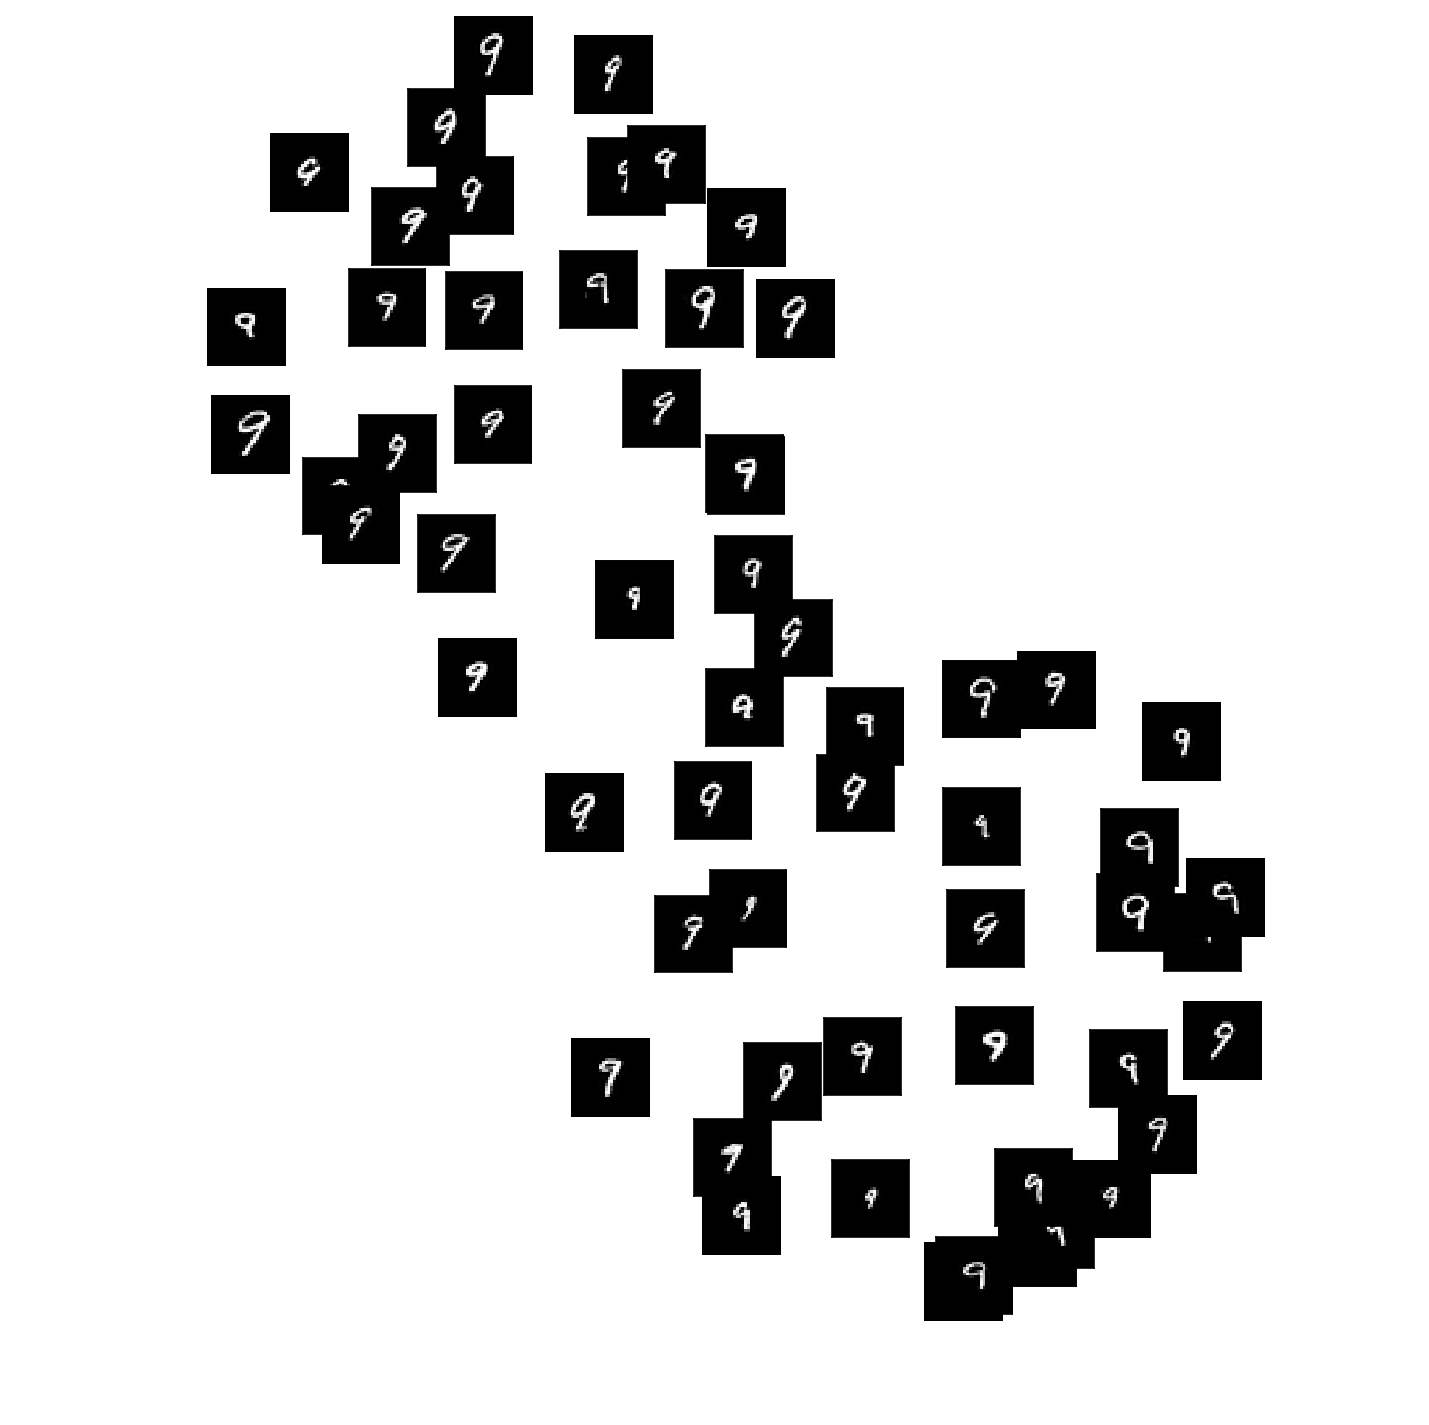

In [1065]:
minv = -15
maxv = 15
side_length = 15
label = 9
# 41:f

coord_list = np.array([[(round(x,2),round(y,2)) for x in np.linspace(minv, maxv, side_length)] 
          for y in np.linspace(minv, maxv, side_length)]).reshape((-1,2))

#fig, axes = plt.subplots(9,9, figsize=(12,12))
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)

actual_pts = []

for i, (x, y) in enumerate(coord_list):
    #ax = axes.flatten()[i]
    
    try:
        img, pt, idx = plot_letter_from_writer_at_latent_space_point(
            x, y, 
            #latent_space=latent_net.z_matrix.numpy(),
            #latent_space=latent_net.zmu.numpy(),
            latent_space=tsne_latent_mu,
            #latent_space=tsne_latent,
            label=label)
        actual_pts.append(pt)
        relative_pos = (pt-minv)/(maxv-minv)
        bt_01 = np.vectorize(lambda x: max(min(x,1),0))
        inset1 = fig.add_axes([bt_01(relative_pos)[0], bt_01(relative_pos)[1], 
                               1/(1.5*side_length), 1/(1.5*side_length)], label=i)
        plt.setp(inset1, xticks=[], yticks=[])
        inset1.imshow(img, cmap='Greys')
    except:
        pass
    
    ax.axis('off')

actual_pts = np.array(actual_pts)
    

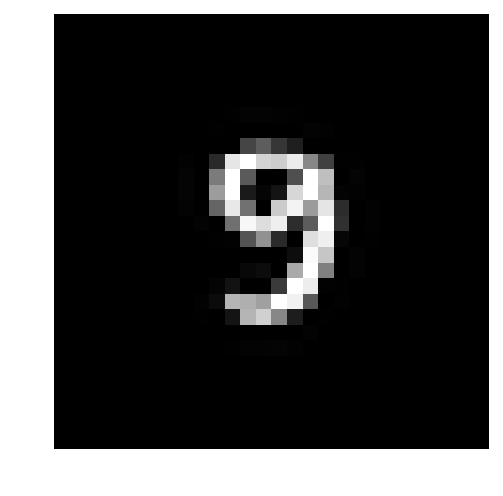

In [908]:
plt.imshow(find_x_with_specific_label(x_train, y_train, 9, 970).reshape((28,28)), cmap='Greys')
plt.axis('off');

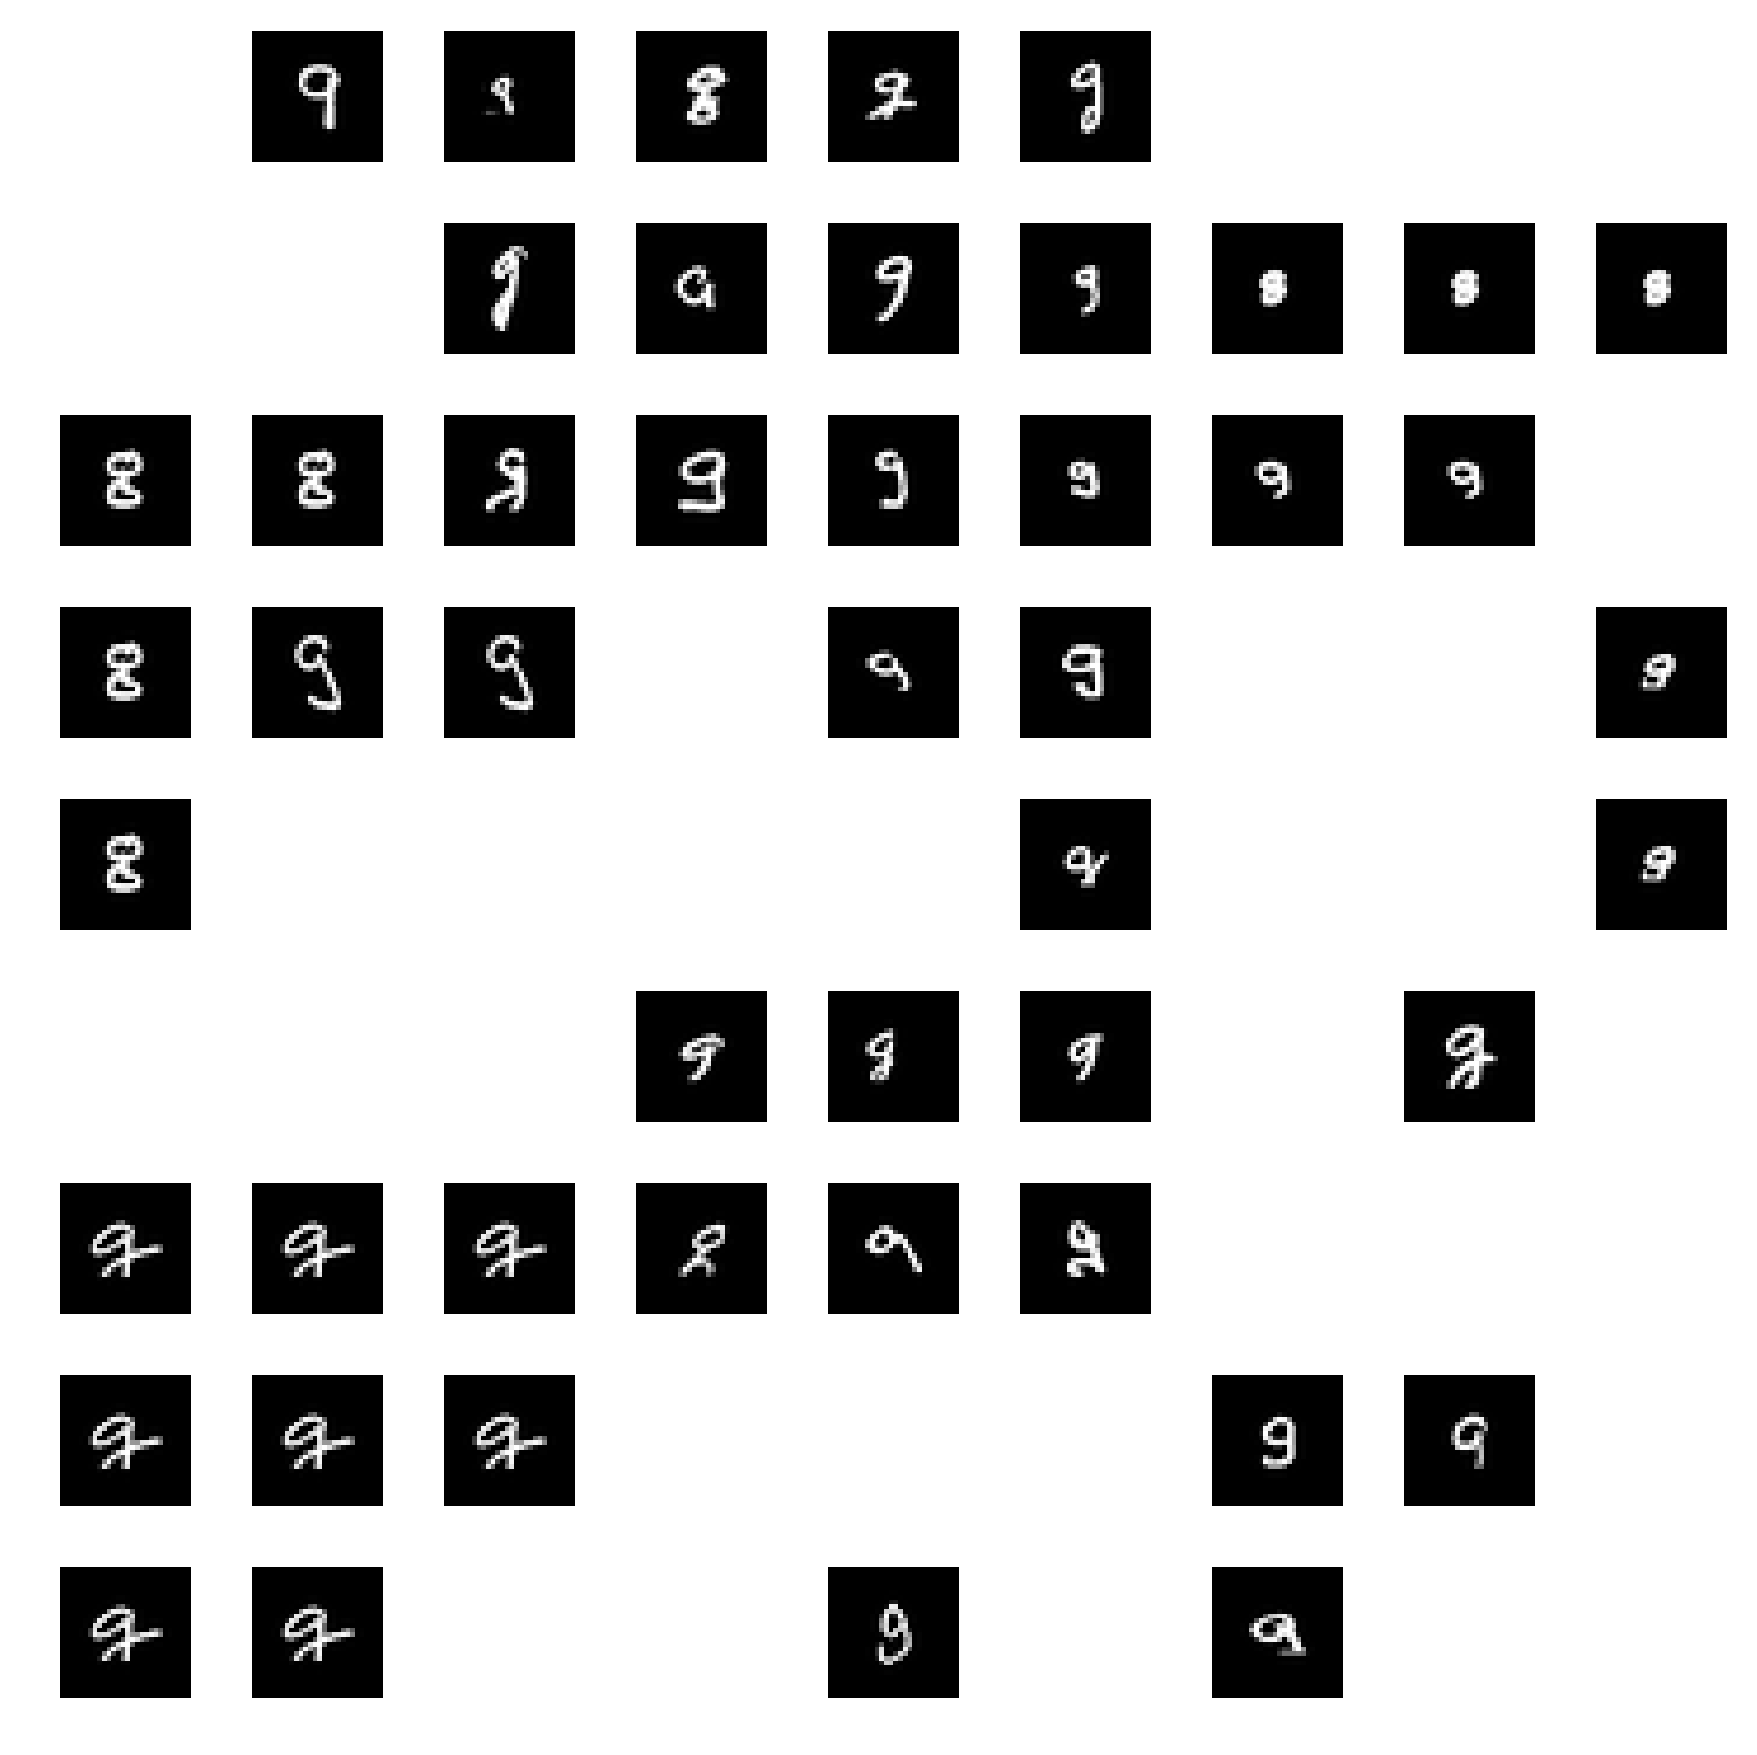

In [894]:
minv = -8
maxv = 8
step = 2
coord_list = np.array([[(round(x,2),round(y,2)) for x in np.arange(minv, maxv+step, step)] 
          for y in np.arange(minv, maxv+step, step)]).reshape((-1,2))

fig, axes = plt.subplots(9,9, figsize=(12,12))

actual_pts = []

for i, (x, y) in enumerate(coord_list):
    ax = axes.flatten()[i]
    
    try:
        img, pt, idx = plot_letter_from_writer_at_latent_space_point(
            x, y, 
            #latent_space=latent_net.z_matrix.numpy(),
            latent_space=tsne_latent,
            label=42)
        actual_pts.append(pt)
        ax.imshow(img, cmap='Greys')
    except:
        pass
    
    ax.axis('off')

actual_pts = np.array(actual_pts)
plt.tight_layout(pad=0)
    

In [164]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [154]:
partitioned_data_dict = {
        gid: [
        arr[np.where(users_train_id == gid)[0]] 
        for arr 
        in [x_train, y_train.argmax(axis=1)]
    ] + [
        arr[np.where(users_test_id == gid)[0]] 
        for arr 
        in [x_test, y_test.argmax(axis=1)]
    ] + [
        arr[np.where(arr == gid)[0]] 
        for arr 
        in [users_train_id, users_test_id]
    ]
    for gid 
    in np.unique(users_train_id)
}

In [168]:
%load_ext autoreload
%autoreload 2
from models import LatentVarNet3000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
opt = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
latent3000 = LatentVarNet3000(opt, loss_fn, 10, 'small')

In [172]:
latent3000.train(
    [x_train.astype(np.float32), y_train.argmax(axis=1), 
     x_test.astype(np.float32), y_test.argmax(axis=1), 
     users_train_id, users_test_id], partitioned_data_dict,
 100, 5, 1)

--- Epoch 0 ---
Test accuracy: 0.4686, 10th percentile: 0.1755, 90th percentile: 0.7109
--- Epoch 1 ---
Test accuracy: 0.5962, 10th percentile: 0.2941, 90th percentile: 0.8125
--- Epoch 2 ---
Test accuracy: 0.6753, 10th percentile: 0.4076, 90th percentile: 0.875
--- Epoch 3 ---
Test accuracy: 0.7028, 10th percentile: 0.3989, 90th percentile: 0.888
--- Epoch 4 ---
Test accuracy: 0.7226, 10th percentile: 0.4269, 90th percentile: 0.9038


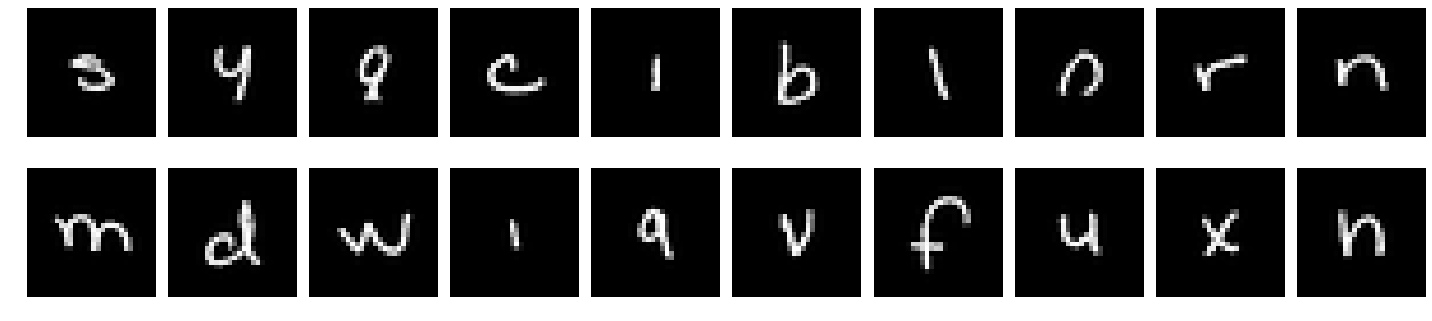

In [424]:
train_id = x_train[np.where(users_train_id == 148)[0]]

fig, axes = plt.subplots(2,10, figsize=(20,5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    try:
        ax.imshow(train_id[i+140].reshape(28,28), cmap='Greys')
    except:
        pass
    ax.axis('off')
plt.tight_layout()

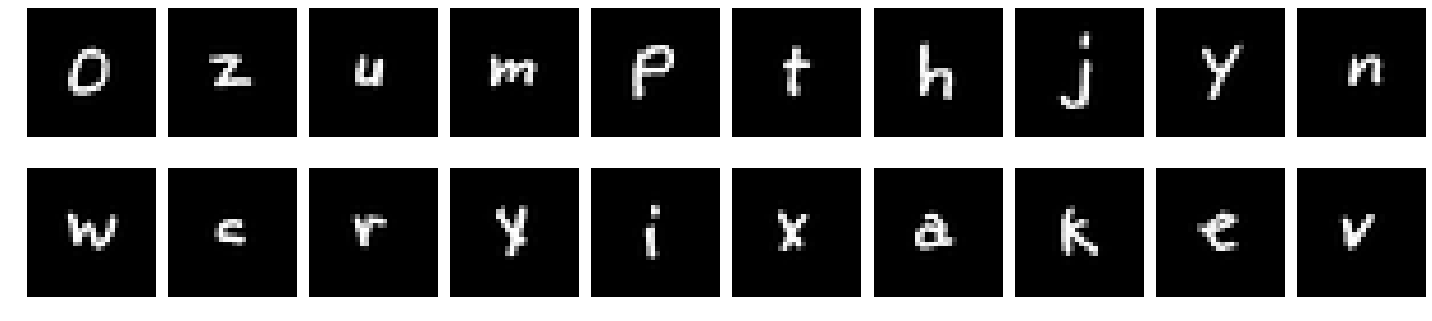

In [417]:
train_id = x_train[np.where(users_train_id == 84)[0]]

fig, axes = plt.subplots(2,10, figsize=(20,5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    try:
        ax.imshow(train_id[i+20].reshape(28,28), cmap='Greys')
    except:
        pass
    ax.axis('off')
plt.tight_layout()

In [284]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [357]:
accuracy_score(y_true = y_test.argmax(axis=1),
               y_pred =latent_net(x_test, users_test_id).numpy().argmax(axis=1))

0.4856577645895153

In [358]:
roc_auc_score(y_true= y_test,y_score=latent_net(x_test, users_test_id).numpy())

0.9200459112213788

In [123]:
ffnn = Sequential([
    Input(shape=(784)),
    #Dropout(0.99),
    Dense(256),
    Dense(128),
    #Conv2D(8,3),
    Dense(62, activation='softmax')
])

ffnn = Sequential([
    Reshape((28,28,1), input_shape=(784,)),
    Conv2D(16, 3),
    MaxPooling2D(),
    Conv2D(32, 3),
    MaxPooling2D(),
    Flatten(),
    #Dense(100, activation='relu'),
    Dense(62, activation='softmax')
])

ffnn.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['acc'])

In [124]:
ffnn.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 62)              

In [125]:
ffnn.fit(x_train, y_train, batch_size=200, epochs=10, verbose=1);

Train on 35535 samples
Epoch 1/10
35535/35535 [==============================] - 5s 141us/sample - loss: 2.6526 - acc: 0.3619
Epoch 2/10
35535/35535 [==============================] - 5s 137us/sample - loss: 1.3208 - acc: 0.6423
Epoch 3/10
35535/35535 [==============================] - 5s 145us/sample - loss: 1.0262 - acc: 0.7130
Epoch 4/10
35535/35535 [==============================] - 6s 161us/sample - loss: 0.8732 - acc: 0.7504
Epoch 5/10
35535/35535 [==============================] - 5s 147us/sample - loss: 0.7718 - acc: 0.7727
Epoch 6/10
35535/35535 [==============================] - 5s 150us/sample - loss: 0.7023 - acc: 0.7895
Epoch 7/10
35535/35535 [==============================] - 5s 147us/sample - loss: 0.6561 - acc: 0.8003
Epoch 8/10
35535/35535 [==============================] - 5s 145us/sample - loss: 0.6171 - acc: 0.8115
Epoch 9/10
35535/35535 [==============================] - 5s 147us/sample - loss: 0.5888 - acc: 0.8184
Epoch 10/10
35535/35535 [=========================

In [126]:
ffnn.evaluate(x_test, y_test)

4044/4044 [==============================] - 0s 72us/sample - loss: 0.6446 - acc: 0.7972


[0.6445526871553868, 0.7972305]

In [294]:

# num_groups=10

# joint = tfd.JointDistributionSequential([
    
# ])

In [31]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score

In [127]:
accuracy_score(y_true=y_test.argmax(axis=1), y_pred=ffnn.predict(x_test).argmax(axis=1))

0.7972304648862513

In [128]:
precision_score(y_true=y_test.argmax(axis=1), 
                y_pred=ffnn.predict(x_test).argmax(axis=1),
                average='weighted')

0.7962848584508557

In [129]:
roc_auc_score(y_true=y_test, y_score=ffnn.predict(x_test), average='weighted')

0.9935926820406172

In [35]:
import string
labels = list(string.digits + string.ascii_lowercase + string.ascii_uppercase)

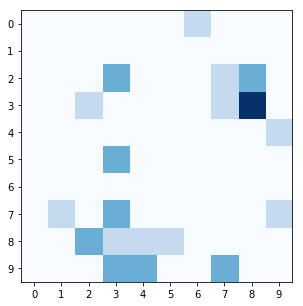

In [130]:
plt.figure(figsize=(5,5))

conf_matrix = confusion_matrix(
    y_true=y_test.argmax(axis=1), 
    y_pred=ffnn.predict(x_test).argmax(axis=1))[:10,:10]
plt.imshow(conf_matrix - np.diag(np.diag(conf_matrix)), cmap='Blues')
plt.xticks(ticks=range(10), labels=list(string.digits))
plt.yticks(ticks=range(10), labels=list(string.digits));

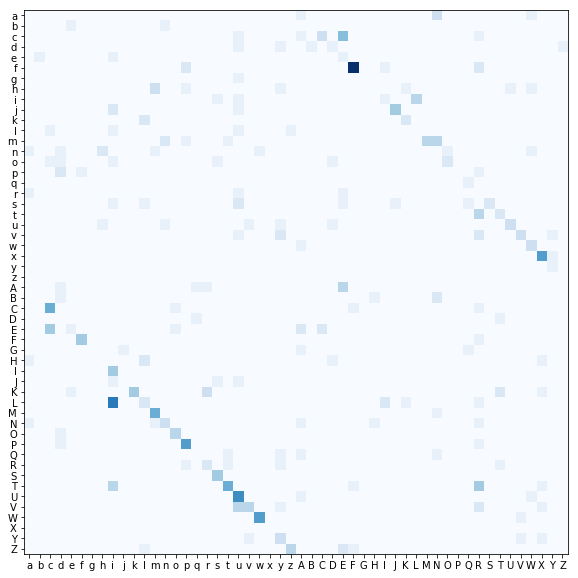

In [131]:
plt.figure(figsize=(10,10))

conf_matrix = confusion_matrix(
    y_true=y_test.argmax(axis=1), 
    y_pred=ffnn.predict(x_test).argmax(axis=1))[10:,10:]
plt.imshow(conf_matrix - np.diag(np.diag(conf_matrix)), 
          cmap='Blues')
plt.xticks(ticks=range(52), labels=list(string.ascii_lowercase + string.ascii_uppercase))
plt.yticks(ticks=range(52), labels=list(string.ascii_lowercase + string.ascii_uppercase));

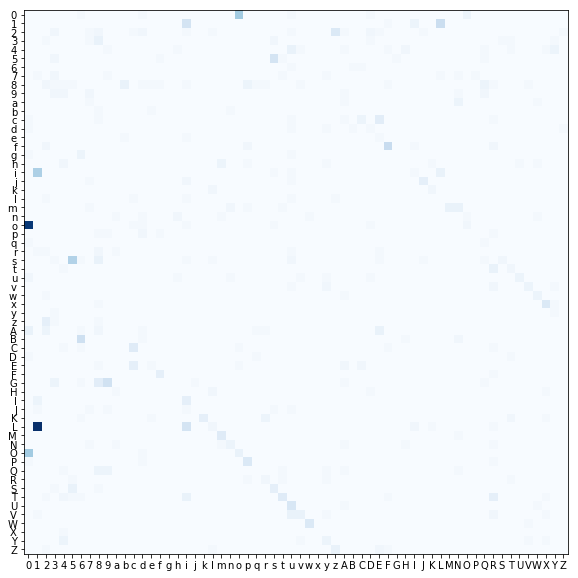

In [132]:
plt.figure(figsize=(10,10))
conf_matrix = confusion_matrix(
    y_true=y_test.argmax(axis=1), 
    y_pred=ffnn.predict(x_test).argmax(axis=1))
plt.imshow(conf_matrix - np.diag(np.diag(conf_matrix)), cmap='Blues')
plt.xticks(ticks=range(62), labels=labels)
plt.yticks(ticks=range(62), labels=labels);

In [189]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

# Build model.
model = tfk.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

# Make predictions.
yhat = model(x_tst)

### Try model

In [317]:
mu1 = np.array([3.], dtype=np.float32)
mu2 = np.array([6.], dtype=np.float32)
sd1 = np.array([2.], dtype=np.float32)
sd2 = np.array([1.], dtype=np.float32)

In [318]:
n1 = tfd.Normal(loc=mu1, scale=sd1)
n2 = tfd.Normal(loc=mu2, scale=sd2)

In [335]:
samp1 = n1.sample(500).numpy()
samp2 = n2.sample(1000).numpy()
data = np.concatenate([samp1,samp2])
#labels = np.concatenate([np.zeros((500)), np.ones((1000))])
labels1 = tfd.Bernoulli(probs=1/3).sample(500).numpy()
labels2 = tfd.Bernoulli(probs=1/6).sample(1000).numpy()
labels = np.concatenate([labels1, labels2])

(array([ 10.,  33., 104., 210., 258., 210., 122.,  43.,   8.,   2.]),
 array([3.0597727, 3.703396 , 4.347019 , 4.9906425, 5.634266 , 6.2778893,
        6.9215126, 7.565136 , 8.208759 , 8.852383 , 9.496006 ],
       dtype=float32),
 <a list of 10 Patch objects>)

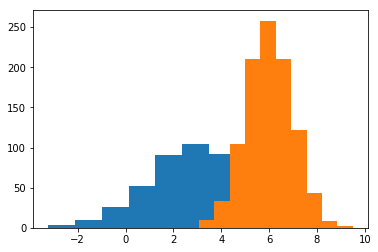

In [321]:
plt.hist(samp1)
plt.hist(samp2)

In [208]:
mu1 = np.array([1.,5.])
mu2 = np.array([-1., 10.])
cov1 = np.array([[5.,-2.], 
                 [-2.,3]])/5
cov2 = np.array([[4.,5.], 
                 [5.,30]])/5
np.linalg.eigvals(cov1), np.linalg.eigvals(cov2)

(array([1.2472136, 0.3527864]), array([0.61432234, 6.18567766]))

In [209]:
mvn1 = tfd.MultivariateNormalFullCovariance(loc=mu1, covariance_matrix=cov1)
mvn2 = tfd.MultivariateNormalFullCovariance(loc=mu2, covariance_matrix=cov2)

In [210]:
samp1 = mvn1.sample(5000).numpy()
samp2 = mvn2.sample(10000).numpy()
samp = np.concatenate([samp1,samp2])
data = samp[:,0, np.newaxis]
labels = samp[:,1, np.newaxis]
groups = np.concatenate([np.zeros((5000)), np.ones((10000))]).astype(int)

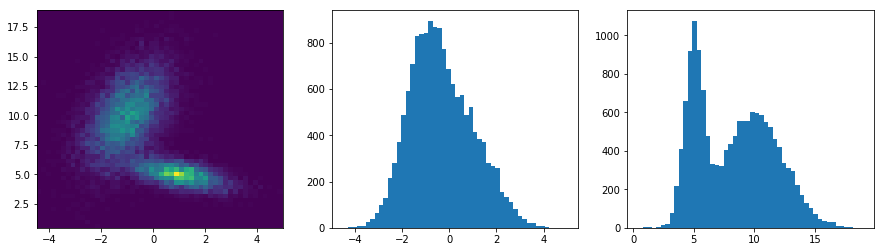

In [211]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.hist2d(samp[:,0], samp[:,1], bins=50)
plt.subplot(132)
plt.hist(samp[:,0], bins=50)
plt.subplot(133)
plt.hist(samp[:,1], bins=50);


In [107]:
tfd.Independent(
            distribution=tfd.MultivariateNormalDiag(loc=np.zeros(4), scale_identity_multiplier=np.ones(2)),
    reinterpreted_batch_ndims=1)

<tfp.distributions.Independent 'IndependentMultivariateNormalDiag/' batch_shape=[] event_shape=[2, 4] dtype=float64>

In [212]:
class LatentVarNet(tf.keras.Model):
    
    def __init__(self):
        """
        inputs = keras.Input(shape=(784,), name='img')
        x = layers.Dense(64, activation='relu')(inputs)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(10, activation='softmax')(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
        """
        super(LatentVarNet, self).__init__()
        
        self.fc1 = Dense(4, activation='relu', )
        #self.fc12 = Dense(4, activation='relu')
        self.fc2 = Dense(4, activation='relu')
        #self.fc22 = Dense(4, activation='relu')
        #self.z_matrix = tf.random.normal([2, 1], mean=0, stddev=1/10)
        self.z_matrix = tfd.Independent(
            distribution=tfd.MultivariateNormalDiag(loc=np.zeros(3), scale_identity_multiplier=np.ones(2)),
            reinterpreted_batch_ndims=1, name='z_matrix')
        self.fc_out = Dense(1)
        self.fc_out2 = Dense(1)
        #self.z_mean = tf.random.normal([num_z_vars, args.dim_z], mean=0, stddev=1/10)
        #self.z_logvar = tf.random.normal([num_z_vars, args.dim_z], mean=0, stddev=1/10)
        #self.z_prior_stdv = tf.Variable([1.])
        #self.z_prior_mean = tf.Variable([0.])
        
    def call(self, x,
            k
            ):
        z_matrix_sample = self.z_matrix.sample(x.shape[0])
        #assert len(k.shape) == 1, 'k must be 1-d vector'
        z = np.stack([z_matrix_sample[i][ki,:] for i, ki in enumerate(k)])
        x = tf.concat([x, z], axis=1)
        y = x 
        x = self.fc1(x)
        y = self.fc2(y)
        x = self.fc_out(x)
        y = self.fc_out(y)
        return tfd.Normal(loc=x, scale=y).sample()

In [213]:
latent_net = LatentVarNet()

In [214]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()



def batch_generator(x, y, z, batch_size=100):
    size = x.shape[0]
    indexes = np.random.permutation(size)
    i = 0
    while True:
        idx = indexes[i:i+batch_size]
        yield x[idx], y[idx], z[idx]
        i = (i + batch_size) % size
        
def create_batch_partition(x, y, z, batch_size=100):
    size = x.shape[0]
    indexes = np.random.permutation(size)
    i = 0
    data = []
    while i < size:
        idx = indexes[i:i+batch_size]
        data.append((x[idx], y[idx], z[idx]))
        i = (i + batch_size)
    return data

train_generator = create_batch_partition(data, labels, groups, batch_size=100)
latent_net = LatentVarNet()

for epoch in range(6):
    print('Start of epoch {}'.format(epoch,))
  
    # Iterate over the batches of the dataset.
    
    for step, (x, y, z) in enumerate(train_generator):
        with tf.GradientTape() as tape:
            out = latent_net(x,
                            z
                            )
            loss = mse_loss_fn(y_true=y, y_pred=out)
    
        grads = tape.gradient(loss, latent_net.trainable_weights)
        optimizer.apply_gradients(zip(grads, latent_net.trainable_weights))
    
        loss_metric(loss)
        if step % 50 == 0:
            print('step {}: mean loss = {}'.format(step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = 102.69541931152344
step 50: mean loss = 34.53189468383789
step 100: mean loss = 21.166465759277344
Start of epoch 1
step 0: mean loss = 16.47429847717285
step 50: mean loss = 14.110836029052734
step 100: mean loss = 12.733816146850586
Start of epoch 2
step 0: mean loss = 11.77587604522705
step 50: mean loss = 11.106274604797363
step 100: mean loss = 10.61610221862793
Start of epoch 3
step 0: mean loss = 10.220681190490723
step 50: mean loss = 9.903458595275879
step 100: mean loss = 9.658268928527832
Start of epoch 4
step 0: mean loss = 9.433589935302734
step 50: mean loss = 9.240716934204102
step 100: mean loss = 9.098576545715332
Start of epoch 5
step 0: mean loss = 8.954254150390625
step 50: mean loss = 8.836384773254395
step 100: mean loss = 8.741500854492188


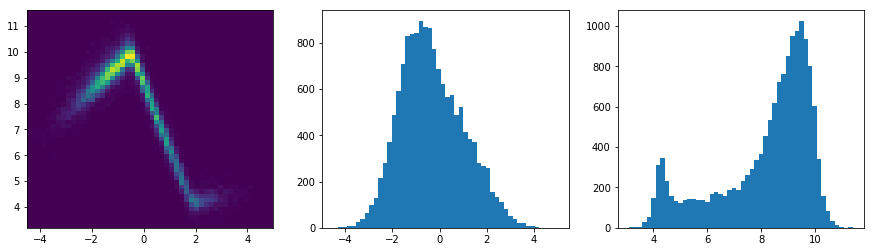

In [215]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.hist2d(data.flatten(), latent_net(data, groups).numpy().flatten(), bins=50)
plt.subplot(132)
plt.hist(data.flatten(), bins=50)
plt.subplot(133)
plt.hist(latent_net(data, groups).numpy().flatten(), bins=50);

In [217]:
latent_net.z_matrix.mean()

<tf.Tensor: id=14296820, shape=(2, 3), dtype=float64, numpy=
array([[0., 0., 0.],
       [0., 0., 0.]])>